# Creating a Deep Learning iOS App with Keras and Tensorflow

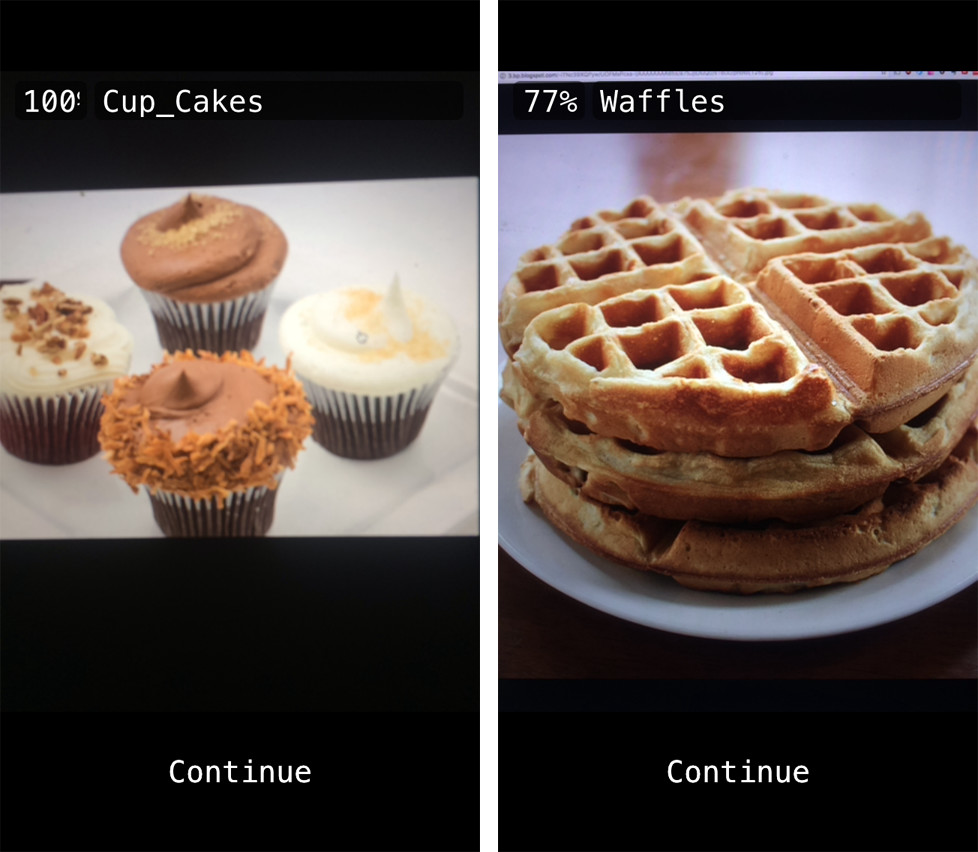

In [112]:
from IPython.display import display, Image
display(Image('./mobile.jpg'))

## Introduction

**CODE AVAILABLE @ https://github.com/stratospark/food-101-mobile**

In a previous project, I showed how to train a Convolutional Neural Network to [classify food images using Keras/Tensorflow](http://blog.stratospark.com/deep-learning-applied-food-classification-deep-learning-keras.html). We also saw how to export the model to [Keras.js](https://github.com/transcranial/keras-js) for use in a HTML5/Javascript browser application.

For this next writeup, I'll show how to take the same model and prepare it for use in a mobile app. I only have experience with iOS devices and only have an iPhone for testing, but the process of extracting, modifying, and serializing the computation graphs should apply for Android deployments as well.

Here is a video capture of the app running on my development device, an iPhone 5s. BTW, all food in the screenshots and video are *vegan*! ;)

<iframe width="560" height="315" src="https://www.youtube.com/embed/nYprPrCTwrA" frameborder="0" allowfullscreen></iframe>

I originally trained the model using **Tensorflow 0.11.0 and Keras 1.1.2**.

For this project, I am using the newer **Tensorflow 1.0.1 and Keras 1.2.2**.

I am not aware of any incompatibilities with taking a model trained with an older version of Tensorflow and using it for inference in a new version of Tensorflow. However, I could be wrong. Of course, Keras 2 has come out since I started this project and have not had time to test.

### Caveats (Major!)

I consider the code here to be very hacky! There is not much documentation online about preparing Keras models for Mobile Tensorflow apps. I am also not an experienced iOS developer. I mainly wanted to prove to myself that this can work, then refine my approach in the future. I would appreciate feedback on any of these issues:

1. When running the app on the device, the inference randomly stops working. The video feed still updates, but no more predictions are made. I can't seem to find a way to reproduce this issue reliably, but it is very common. I noticed a recent open issue that may be related: [Tensorflow freezes on iOS during Session::Run](https://github.com/tensorflow/tensorflow/issues/7108)
1. I do not know if I am getting full performance from Tensorflow on iOS. I am doing a standard build of Tensorflow from my MacBook Pro. There are apparently some [undocumented flags that can turn on optimization](http://stackoverflow.com/questions/37971426/tensorflow-running-slow-on-ios), but I don't know if they apply to the current version. In any case, I do seem to achieve 1-1.5 sec per inference on my iPhone 5s.
1. The level of accuracy that I achieved in my previous writeup depended on 10-crops at particular positions in an image. I am sticking with whatever came with the example app sample code to handle resizing of a single crop. I don't know how the portrait orientation of the camera affects accuracy when resizing the image to the 299x299 size needed by the InceptionV3 network.
1. I don't know if I'm dealing without dropout properly, as a result, the difference between the original model predictions and the modified model predictions are slightly higher than I would have thought. In a production system, I would **definitely** want to run through my test images on the device in order to compare test set accuracy with the original model.
1. I wasn't able to get weight quantization to work properly. I may need to manually find the min/max ranges.
1. I am getting non-deterministic results when evaluating the optimized models from disk to compare predictions.

### Helpful Resources

Before trying to replicate what I have done here, know that there are probably better ways of doing this! 

Here are some resources that can help you explore other paths, some that achieve much better performance than what I have here.

* [Squeezing Deep Learning Into Mobile Phones](https://www.slideshare.net/anirudhkoul/squeezing-deep-learning-into-mobile-phones), excellent slides by Anirudh Koul that summarize various options available for mobile Deep Learning apps. I like how he breaks it down depending on how much time you want to invest (1 day, 1 week, 1 month, 6 months, etc.)
* Matthijs Hollemans's [Machinethink Blog](http://machinethink.net/blog/). Great, in-depth blog posts about Deep Learning on iOS. Includes coverage of BNNS, Metal Performance Shaders, etc. 
* Matt Rajca's articles: [Getting Started with Deep MNIST and TensorFlow on iOS](http://www.mattrajca.com/2016/11/25/getting-started-with-deep-mnist-and-tensorflow-on-ios.html) and [Speeding Up TensorFlow with Metal Performance Shaders](http://www.mattrajca.com/2016/11/26/speeding-up-tensorflow-with-metal-performance-shaders.html)
* Apple Developer example, [MetalImageRecognition: Performing Image Recognition with Inception_v3 Network using Metal Performance Shaders Convolutional Neural Network routines](https://developer.apple.com/library/content/samplecode/MetalImageRecognition/Introduction/Intro.html). Code that implements the same InceptionV3 network that I am utilizing here, but probably much, much faster!

And though I don't believe it supports iOS at the moment, keep an eye out for [Tensorflow XLA compiler](https://www.tensorflow.org/versions/master/experimental/xla/). In the future, we might be able to do mobile-specific builds, which will allow us to execute our computation graphs on a mobile device without having to have the entire Tensorflow inference library. This could allow for dramatic size reductions and possibly speedups!

All in all, Deep Learning on mobile is looking bright! Hopefully it becomes easier and more straightforward to get your trained models running efficiently on a device.

## Step by Step

First of all, download this trained Keras model and move it into the `model_export` folder if you want to follow along:

`wget https://s3.amazonaws.com/stratospark/food-101/model4b.10-0.68.hdf5`

At a high level, we will need to:

* Reload the Keras model from disk into the Tensorflow session.
* Extract the computation graph from the session object.
* Change all `Switch` nodes to pass the value of the `True` branch as an `Identity` op instead.
* Bypass the `Dropout` nodes.
* Update the `keras_learning_phase` `Placeholder` node to be a `Const` node always outputting Test mode.
* Add the neuron weights to the graph as constants.
* Serialize the graph to a .pb file.
* Build optimization tools with Bazel
* Run optimization graph transformations
* Add model to Tensorflow iOS Camera sample project

### Load Keras model and extract the `GraphDef`

In [2]:
import tensorflow as tf
from keras.models import load_model, Model
from keras import backend as K

sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


In [4]:
model = load_model('./model4b.10-0.68.hdf5')

In [5]:
gd = sess.graph.as_graph_def()
print(len(gd.node), 'Nodes')
gd.node[:2]

(40271, 'Nodes')


[name: "input_1"
 op: "Placeholder"
 attr {
   key: "dtype"
   value {
     type: DT_FLOAT
   }
 }
 attr {
   key: "shape"
   value {
     shape {
     }
   }
 }, name: "random_uniform/shape"
 op: "Const"
 attr {
   key: "dtype"
   value {
     type: DT_INT32
   }
 }
 attr {
   key: "value"
   value {
     tensor {
       dtype: DT_INT32
       tensor_shape {
         dim {
           size: 4
         }
       }
       tensor_content: "\003\000\000\000\003\000\000\000\003\000\000\000 \000\000\000"
     }
   }
 }]

### Testing Model

Let's sanity check our Keras model and save the predicted values. We will use this later on to compare against the optimized mobile model.

In [6]:
x = tf.placeholder(tf.float32, shape=model.get_input_shape_at(0))

In [7]:
y = model(x)

In [8]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
img = plt.imread('sushi.png')

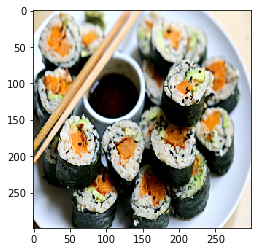

In [10]:
plt.imshow(img)

In [11]:
def preprocess_input(x):
    x_copy = np.copy(x)
    x_copy -= 0.5
    x_copy *= 2.
    return x_copy

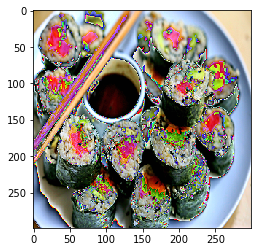

In [12]:
img_processed = preprocess_input(img)
plt.imshow(img_processed)

In [13]:
imgs = np.expand_dims(img_processed, 0)

In [14]:
orig_scores = sess.run(y, feed_dict={x: imgs, K.learning_phase(): False})

In [15]:
def find_top_pred(scores):
    top_label_ix = np.argmax(scores) # label 95 is Sushi
    confidence = scores[0][top_label_ix]
    print('Label: {}, Confidence: {}'.format(top_label_ix, confidence))
    
find_top_pred(orig_scores)

Label: 95, Confidence: 0.998208284378


### Replace `Switch` Nodes with `Identity`

There are many `Switch` nodes which are introduced by Keras to handle different paths through the computation graph depending on whether one is Training or Testing.

We are only going to use inference within the mobile app, and besides, the `Switch` op is not implemented by default in the default Tensorflow mobile builds.

Therefore, we want to find all the `Switch` nodes and turn them into `Identity` nodes that 

In [16]:
nodes_with_switch_op = [x for x in gd.node if x.op.lower().find('switch') != -1]
nodes_with_switch_op[0]

name: "cond/Switch"
op: "Switch"
input: "keras_learning_phase"
input: "keras_learning_phase"
attr {
  key: "T"
  value {
    type: DT_BOOL
  }
}

Let's create a dict so we can lookup the nodes by name:

In [17]:
nodes = {}
for node in gd.node:
    nodes[node.name] = node

In [18]:
print(len(nodes_with_switch_op))
[(n.name, [i for i in n.input]) for n in nodes_with_switch_op[:10]]

570


[(u'cond/Switch', [u'keras_learning_phase', u'keras_learning_phase']),
 (u'cond/Switch_1', [u'batchnorm/add_1', u'cond/pred_id']),
 (u'cond/Switch_2', [u'batchnorm_1/add_1', u'cond/pred_id']),
 (u'cond_1/Switch', [u'keras_learning_phase', u'keras_learning_phase']),
 (u'cond_1/Switch_1', [u'batchnorm_2/add_1', u'cond_1/pred_id']),
 (u'cond_1/Switch_2', [u'batchnorm_3/add_1', u'cond_1/pred_id']),
 (u'cond_2/Switch', [u'keras_learning_phase', u'keras_learning_phase']),
 (u'cond_2/Switch_1', [u'batchnorm_4/add_1', u'cond_2/pred_id']),
 (u'cond_2/Switch_2', [u'batchnorm_5/add_1', u'cond_2/pred_id']),
 (u'cond_3/Switch', [u'keras_learning_phase', u'keras_learning_phase'])]

Let's look up one of the `Switch` nodes, as well as one of it's input nodes.

In [19]:
nodes['cond/Switch_1']

name: "cond/Switch_1"
op: "Switch"
input: "batchnorm/add_1"
input: "cond/pred_id"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "_class"
  value {
    list {
      s: "loc:@batchnorm/add_1"
    }
  }
}

In [20]:
nodes['cond/pred_id']

name: "cond/pred_id"
op: "Identity"
input: "keras_learning_phase"
attr {
  key: "T"
  value {
    type: DT_BOOL
  }
}

We also stumble upon this `Merge` node, that seems to take the `Switch` node as an input:

In [21]:
for n in gd.node:
    if 'cond/Switch_2' in [i for i in n.input]:
        print n

name: "cond/Merge"
op: "Merge"
input: "cond/Switch_2"
input: "cond/Switch_1:1"
attr {
  key: "N"
  value {
    i: 2
  }
}
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}



Looking through the different nodes, we can see that some nodes take a `Switch` node as an input. In some cases, there is a `:1` appended to the actual name of the node. I believe this stands for the output of a `Switch` node when it is true. **If anyone reading this knows for sure what that means, let me know.** Since there are no nodes with that name, through trial and error, I was able to get the model to run by routing those to the actual `Switch` node name.

Below, we change the inputs of all nodes that take in a `Switch:1` input to remove the last 2 characters:

In [22]:
nodes['cond/Merge']

name: "cond/Merge"
op: "Merge"
input: "cond/Switch_2"
input: "cond/Switch_1:1"
attr {
  key: "N"
  value {
    i: 2
  }
}
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}

In [23]:
# nodes to reroute switch input
for n in [x for x in gd.node]:
    ints = [i for i in n.input]
    endswith1 = [ii for ii in ints if ii.endswith(':1')] #and 'Switch' in ii]
    if len(endswith1) > 0:
        for index, inn in enumerate(n.input):
            if inn in endswith1:
                new_input = inn[:-2]
                n.input.remove(inn)
                n.input.insert(index, new_input)

Finally, let's change those `Switch` nodes to `Identity` nodes, and also remove the input value that will not be used.

In [24]:
for n in nodes_with_switch_op:
    n.op = 'Identity'
    n.input.pop()

### Bypass `Dropout` Nodes

From various reports online, we need to remove `Dropout` nodes when running inference on mobile devices. I found these two places offering code guidance:

* https://dato.ml/drop-dropout-from-frozen-model/
* http://stackoverflow.com/questions/40358892/wipe-out-dropout-operations-from-tensorflow-graph

In addition, there is a ticket opened for Tensorflow to automatically do this when running an optimize script: https://github.com/tensorflow/tensorflow/issues/5867

In [25]:
[(n.name, [i for i in n.input]) for n in gd.node if n.name.lower().find('dropout') != -1]

[(u'cond_94/dropout/keep_prob', [u'^cond_94/switch_t']),
 (u'cond_94/dropout/Shape', [u'cond_94/mul']),
 (u'cond_94/dropout/random_uniform/min', [u'^cond_94/switch_t']),
 (u'cond_94/dropout/random_uniform/max', [u'^cond_94/switch_t']),
 (u'cond_94/dropout/random_uniform/RandomUniform', [u'cond_94/dropout/Shape']),
 (u'cond_94/dropout/random_uniform/sub',
  [u'cond_94/dropout/random_uniform/max',
   u'cond_94/dropout/random_uniform/min']),
 (u'cond_94/dropout/random_uniform/mul',
  [u'cond_94/dropout/random_uniform/RandomUniform',
   u'cond_94/dropout/random_uniform/sub']),
 (u'cond_94/dropout/random_uniform',
  [u'cond_94/dropout/random_uniform/mul',
   u'cond_94/dropout/random_uniform/min']),
 (u'cond_94/dropout/add',
  [u'cond_94/dropout/keep_prob', u'cond_94/dropout/random_uniform']),
 (u'cond_94/dropout/Floor', [u'cond_94/dropout/add']),
 (u'cond_94/dropout/div', [u'cond_94/mul', u'cond_94/dropout/keep_prob']),
 (u'cond_94/dropout/mul', [u'cond_94/dropout/div', u'cond_94/dropout/Fl

In [26]:
for n in gd.node:
    if 'cond_94/dropout/mul' in [i for i in n.input]:
        print n

name: "cond_94/Merge"
op: "Merge"
input: "cond_94/Switch_1"
input: "cond_94/dropout/mul"
attr {
  key: "N"
  value {
    i: 2
  }
}
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}



In [27]:
nodes['cond_94/mul']

name: "cond_94/mul"
op: "Mul"
input: "cond_94/mul/Switch"
input: "cond_94/mul/y"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}

In [28]:
nodes['cond_94/dropout/mul']

name: "cond_94/dropout/mul"
op: "Mul"
input: "cond_94/dropout/div"
input: "cond_94/dropout/Floor"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}

In [29]:
nodes['cond_94/dropout/mul'].input.pop()
nodes['cond_94/dropout/mul'].input.append('cond_94/mul')

In [30]:
nodes['cond_94/dropout/mul']

name: "cond_94/dropout/mul"
op: "Mul"
input: "cond_94/dropout/div"
input: "cond_94/mul"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}

### Replace `keras_learning_phase` `Placeholder` with `Const` value

We don't need `keras_learning_phase` to be a `Placeholder`, as it should be set to a constant value of `False`, for Test mode. We can set it to a `Const` op, then set it's value to a 1-dimensional tensor containing False. The `shape` attribute is not valid in a `Const` op, so we just delete it:

In [31]:
nodes['keras_learning_phase']

name: "keras_learning_phase"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_BOOL
  }
}
attr {
  key: "shape"
  value {
    shape {
    }
  }
}

In [32]:
nodes['keras_learning_phase'].op = 'Const'

In [33]:
from tensorflow.core.framework import attr_value_pb2
from tensorflow.core.framework import graph_pb2
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import tensor_util

nodes['keras_learning_phase'].attr.get_or_create('value').CopyFrom(attr_value_pb2.AttrValue(tensor=tensor_util.make_tensor_proto(
            [False], dtypes.bool, [1])))

In [34]:
del nodes['keras_learning_phase'].attr['shape']

In [35]:
nodes['keras_learning_phase']

name: "keras_learning_phase"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_BOOL
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_BOOL
      tensor_shape {
        dim {
          size: 1
        }
      }
      bool_val: false
    }
  }
}

### Baking Weight Constants into GraphDef and Writing to Disk

We want our output .pb file to be self contained, with both the computation graph and all the trained weights. To do this, we simply need to `convert_variables_to_constants` assuming we want to run the computation all the way up to the `Softmax` output, which will give us the 101 class probabilities.

In [36]:
from tensorflow.python.framework import graph_util

output_graph_def = graph_util.convert_variables_to_constants(sess, gd, ['Softmax'])

INFO:tensorflow:Froze 566 variables.
Converted 566 variables to const ops.


In [37]:
with tf.gfile.GFile('graph.pb', "wb") as f:
    f.write(output_graph_def.SerializeToString())

### Testing the Modified Model

In [82]:
K.clear_session()
sess = tf.Session()
K.set_session(sess)

In [83]:
from tensorflow.core.framework import graph_pb2
with open('graph.pb', "rb") as f:
    output_graph_def = graph_pb2.GraphDef()
    output_graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(output_graph_def, name="")

In [84]:
x = sess.graph.get_tensor_by_name('input_1:0')

In [85]:
y = sess.graph.get_tensor_by_name('Softmax:0')

In [93]:
new_scores = sess.run(y, feed_dict={x: imgs})

In [95]:
abs((orig_scores - new_scores)) < 1e-6

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True]], dtype=bool)

The scores have changed due to our modifications to the dropout node, but not by much. We also get the same predicted label with a similar confidence level:

In [97]:
find_top_pred(orig_scores)
find_top_pred(new_scores)

Label: 95, Confidence: 0.998208284378
Label: 95, Confidence: 0.999539613724


### Optimize the Model for Inference

I originally intended to follow Pete Warden's Tutorial: [Tensorflow for Mobile Poets](https://petewarden.com/2016/09/27/tensorflow-for-mobile-poets/). In that tutorial, he takes an InceptionV3 network and runs it through some optimizations to reduce the number of operations, decrease the resolutions of the weights, and overall make the network smaller and faster.

Then, I discovered the Tensorflow [Graph Transform Tool](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/tools/graph_transforms/README.md), which Pete Warden recommends in a [more recent post](https://petewarden.com/2016/12/30/rewriting-tensorflow-graphs-with-the-gtt/).

First you need to:
* Do a local build of Tensorflow: https://www.tensorflow.org/install/install_sources, making sure you install Bazel correctly and have executed ./configure
* Build the following tools from within your tensorflow folder:

```
bazel build tensorflow/tools/graph_transforms:transform_graph
bazel build tensorflow/tools/graph_transforms:summarize_graph
bazel build tensorflow/contrib/util:convert_graphdef_memmapped_format
```

Now, let's try the `summarize_graph` utility on the .pb file that we have just exported:

```
(tensorflow) ➜  model_export git:(master) ✗ ../../tensorflow/bazel-bin/tensorflow/tools/graph_transforms/summarize_graph --in_graph=graph.pb

Found 1 possible inputs: (name=input_1, type=float(1), shape=[])
No variables spotted.
Found 1 possible outputs: (name=Softmax, op=Softmax)
Found 21820820 (21.82M) const parameters, 0 (0) variable parameters, and 190 control_edges
Op types used: 1435 Const, 758 Identity, 754 Mul, 565 Add, 376 Sub, 189 Reshape, 188 Rsqrt, 188 Sum, 95 Shape, 95 Prod, 95 Merge, 94 Mean, 94 Gather, 94 StopGradient, 94 SquaredDifference, 94 Conv2D, 94 Square, 94 Reciprocal, 94 Relu, 94 Cast, 15 ConcatV2, 11 AvgPool, 3 MaxPool, 1 Softmax, 1 RealDiv, 1 Placeholder, 1 Pack, 1 StridedSlice, 1 MatMul
To use with tensorflow/tools/benchmark:benchmark_model try these arguments:
bazel run tensorflow/tools/benchmark:benchmark_model -- --graph=graph.pb --show_flops --logtostderr --input_layer=input_1 --input_layer_type=float --input_layer_shape= --output_layer=Softmax
```

In [98]:
!ls -altr graph.pb

-rw-rw-r-- 1 stratospark stratospark 87833459 Mar 22 00:24 graph.pb


Then we can optimize the graph for deployment. Notice that we are rounding the weights so that the file can compress better when added to the device bundle.

```
(tensorflow) ➜  model_export git:(master) ✗ ../../tensorflow/bazel-bin/tensorflow/tools/graph_transforms/transform_graph \
--in_graph=graph.pb \
--out_graph=opt_graph.pb \
--inputs='input_1' \
--outputs='Softmax' \
--transforms='strip_unused_nodes(type=float, shape="1,299,299,3") remove_nodes(op=Identity, op=CheckNumerics) round_weights(num_steps=256) fold_constants(ignore_errors=true) fold_batch_norms fold_old_batch_norms'

2017-03-22 00:35:27.886563: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying strip_unused_nodes
2017-03-22 00:35:28.048049: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying remove_nodes
2017-03-22 00:35:28.709523: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying round_weights
2017-03-22 00:35:29.032210: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_constants
2017-03-22 00:35:29.064884: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-03-22 00:35:29.064910: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-03-22 00:35:29.064914: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-03-22 00:35:29.064917: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-03-22 00:35:29.064919: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use FMA instructions, but these are available on your machine and could speed up CPU computations.
2017-03-22 00:35:29.544610: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_batch_norms
2017-03-22 00:35:29.655708: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_old_batch_norms
```


In [99]:
!ls -altr opt_graph.pb

-rw-rw-r-- 1 stratospark stratospark 87683561 Mar 22 00:35 opt_graph.pb


Next, we can shrink the graph down by quantizing the weights. ** Warning, this does not work on the iOS device! **

```
(tensorflow) ➜  model_export git:(master) ✗ ../../tensorflow/bazel-bin/tensorflow/tools/graph_transforms/transform_graph \
--in_graph=opt_graph.pb \
--out_graph=shrink_graph.pb \
--inputs='input_1' \
--outputs='Softmax' \
--transforms='quantize_weights strip_unused_nodes'

2017-03-22 00:39:51.366052: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying quantize_weights
2017-03-22 00:39:51.913481: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying strip_unused_nodes
```

In [101]:
!ls -altr shrink_graph.pb

-rw-rw-r-- 1 stratospark stratospark 22445591 Mar 22 00:39 shrink_graph.pb


Finally, we can create a memory-mapped model, as described in [Tensorflow for Mobile Poets](https://petewarden.com/2016/09/27/tensorflow-for-mobile-poets/)

```
(tensorflow) ➜  model_export git:(master) ✗ ../../tensorflow/bazel-bin/tensorflow/contrib/util/convert_graphdef_memmapped_format --in_graph=opt_graph.pb --out_graph=mem_graph.pb

2017-03-22 00:40:32.066048: I tensorflow/contrib/util/convert_graphdef_memmapped_format_lib.cc:168] Converted 94 nodes
```

In [102]:
!ls -altr *graph*

-rw-rw-r-- 1 stratospark stratospark 87833459 Mar 22 00:24 graph.pb
-rw-rw-r-- 1 stratospark stratospark 87683561 Mar 22 00:35 opt_graph.pb
-rw-rw-r-- 1 stratospark stratospark 22445591 Mar 22 00:39 shrink_graph.pb
-rw-rw-r-- 1 stratospark stratospark 87693388 Mar 22 00:40 mem_graph.pb


### Testing Optimized Model

In [108]:
def test_model(model_file):
    K.clear_session()
    sess = tf.Session()
    K.set_session(sess)

    with open(model_file, "rb") as f:
        output_graph_def = graph_pb2.GraphDef()
        output_graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(output_graph_def, name="")

    x = sess.graph.get_tensor_by_name('input_1:0')
    y = sess.graph.get_tensor_by_name('Softmax:0')

    new_scores = sess.run(y, feed_dict={x: imgs})
    print((orig_scores - new_scores) < 1e-6)
    find_top_pred(orig_scores)
    find_top_pred(new_scores)
    
test_model('graph.pb')

[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True False  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True]]
Label: 95, Confidence: 0.998208284378
Label: 95, Confidence: 0.99955624342


In [109]:
test_model('opt_graph.pb')

[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True False  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True]]
Label: 95, Confidence: 0.998208284378
Label: 95, Confidence: 0.999923110008


In [110]:
test_model('mem_graph.pb')

DecodeError: Error parsing message

**TODO**: How to test the quantized and memory mapped models with non-mobile Tensorflow?

### Adding Model to Example Tensorflow / iOS Camera App

I used this [example app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/ios_examples/camera) as a base. Here are the main changes:

* Add `mem_graph.pb` file that to the `camera/data` folder. If you didn't buitl it in the previous section, download it here: https://s3.amazonaws.com/stratospark/food-101/mem_graph.pb
* Replace the `model_file_name` variable in `CameraExampleViewController.mm` with `mem_graph`
* Replace labels file with food labels.
* Change input height and width to 299x299, as per InceptionV3 requirements.
* Change `out_pixel[c]` to do InceptionV3 preprocessing: `out_pixel[c] = ((in_pixel[c] / 255.0) - 0.5) * 2.0;`
* Tweak `decayValue, updateValue, minimumThreshold` in `setPredictionValues` method to get a better user experience.
* Be sure to go to `Build Settings` and update `Other Linker Flags`, `Header Search Paths`, and `Library Search Paths` to point to your local build of Tensorflow. This project folder is a sibling of my Tensorflow folder.